In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2 #Mengimpor pustaka OpenCV, yang digunakan untuk pemrosesan citra digital
import numpy as np #untuk manipulasi data berbentuk array atau matriks
import pandas as pd #untuk menyimpan data fitur yang diekstraksi dan memudahkan analisis.
import os #untuk berinteraksi dengan sistem file, seperti membuka dan membaca file dari folder
from tqdm import tqdm #menampilkan progress bar yang menunjukkan status pemrosesan (terutama berguna saat iterasi dalam loop).
from matplotlib import pyplot as plt #visualisasi data berupa grafik dan gambar. Di sini, digunakan untuk menampilkan citra hasil pemrosesan.
from skimage.feature import graycomatrix, graycoprops # ekstraksi fitur tekstur menggunakan metode Gray Level Co-occurrence Matrix (GLCM). graycomatrix menghitung matriks GLCM dan graycoprops digunakan untuk menghitung berbagai fitur dari matriks tersebut seperti kontras, homogenitas, energi, dan korelasi.
from sklearn.model_selection import train_test_split #fungsi train_test_split dari pustaka scikit-learn. Fungsi ini digunakan untuk membagi dataset menjadi data latih (training) dan data uji (testing).
from sklearn.svm import SVC #Mengimpor kelas SVC (Support Vector Classification) dari pustaka scikit-learn, yang digunakan untuk membuat model klasifikasi menggunakan algoritma Support Vector Machine (SVM).
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay #Menghitung akurasi dari model berdasarkan perbandingan prediksi dengan nilai sebenarnya, Menyediakan laporan metrik evaluasi lainnya, seperti precision, recall, dan F1-score, memvisualisasikan confusion matrix yang menunjukkan performa model dalam klasifikasi.
from sklearn.preprocessing import MinMaxScaler

In [3]:
# --- Path Dataset dan Label ---menyimpan path folder ini dalam variabel, Anda dapat memudahkan akses ke dataset gambar untuk pemrosesan selanjutnya, seperti ekstraksi fitur dan pelatihan model.
base_path = '/content/drive/MyDrive/HANA/Palm ripeness dataset(nonbackground)'
labels = ['Masak', 'Mengkal', 'Mentah']
data = []

In [4]:
# --- FUNGSI PENGOLAHAN GAMBAR --- untuk menghapus latar belakang dari gambar berdasarkan anggapan bahwa latar belakang tersebut berwarna putih

# 1. Hapus background (anggap putih sebagai background)
def remove_background(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)
    mask_inv = cv2.bitwise_not(mask)
    result = cv2.bitwise_and(img, img, mask=mask_inv)
    return result, mask_inv

In [5]:
# 2. Visualisasi satu gambar sebelum dan sesudah background dihapus
def show_removed_background(image_path):
    img = cv2.imread(image_path)
    removed, _ = remove_background(img)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    removed_rgb = cv2.cvtColor(removed, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_rgb)
    plt.title("Gambar Asli")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(removed_rgb)
    plt.title("Tanpa Background")
    plt.axis('off')
    plt.show()

In [6]:
# 3. Ekstrak RGB rata-rata dari gambar tanpa background
def extract_rgb(image_path):
    img = cv2.imread(image_path)
    img_nobg, mask = remove_background(img)
    rgb = cv2.cvtColor(img_nobg, cv2.COLOR_BGR2RGB)
    object_pixels = rgb[mask > 0]
    if object_pixels.size == 0:
        return 0, 0, 0
    avg_color = object_pixels.mean(axis=0)
    return avg_color[0], avg_color[1], avg_color[2]

In [7]:
# 4. Ekstrak fitur GLCM dari grayscale
def extract_glcm_features(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    glcm = graycomatrix(gray, distances=[5], angles=[0], symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    return contrast, correlation, energy, homogeneity

In [8]:
# --- PROSES EKSTRAKSI RGB + GLCM ---
for label in labels:
    folder = os.path.join(base_path, label)
    if not os.path.exists(folder):
        print(f"Folder tidak ditemukan: {folder}")
        continue

    for filename in tqdm(os.listdir(folder), desc=f"Memproses {label}"):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            filepath = os.path.join(folder, filename)
            try:
                r, g, b = extract_rgb(filepath)
                contrast, corr, energy, homog = extract_glcm_features(filepath)
                data.append([filename, r, g, b, contrast, corr, energy, homog, label])
            except Exception as e:
                print(f"Gagal memproses {filename}: {e}")

Memproses Mentah: 100%|██████████| 91/91 [02:22<00:00,  1.57s/it]


In [ ]:
# --- Buat Tabel Data ---
df = pd.DataFrame(data, columns=[
    'Filename', 'R', 'G', 'B', 'Contrast', 'Correlation', 'Energy', 'Homogeneity', 'Label'
])

# --- Tampilkan 254 baris pertama dari tabel hasil ekstraksi ---
print("🔹 Contoh 254 baris fitur RGB + GLCM:")
print(df.head(254))

🔹 Contoh 254 baris fitur RGB + GLCM:
            Filename           R          G           B    Contrast  \
0      (1) masak.JPG  111.946198  86.138272   88.252156  261.611862   
1      (2) masak.JPG   99.829741  77.498313   85.962247  163.670043   
2      (3) masak.JPG  101.993411  77.148048   80.569434  228.004978   
3      (4) masak.JPG  110.146335  77.456685   86.645673  174.892636   
4      (5) masak.JPG  106.657456  86.768798   90.137398  330.781862   
..               ...         ...        ...         ...         ...   
249  (87) mentah.jpg   80.672848  83.603189   91.630298  601.510037   
250  (88) mentah.jpg   55.645622  54.202872   59.517520  400.514803   
251  (89) mentah.jpg   84.117584  88.731056  100.547009  310.261625   
252  (90) mentah.jpg   49.703078  49.870272   55.504596  161.443784   
253  (91) mentah.jpg   80.872669  79.884583   83.629375  296.798673   

     Correlation    Energy  Homogeneity   Label  
0       0.979613  0.688750     0.730633   Masak  
1       0.

In [ ]:
# --- Simpan ke Excel ---
df.to_excel('/content/drive/MyDrive/HANA/GABUNGAN RGB & GLCM CODE NEW/RGB_GLCM_Output_Hapus_Background.xlsx', index=False)

# --- IMPOR LIBRARY YANG DIBUTUHKAN ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# --- PILIH FITUR & LABEL ---
X = df[['R', 'G', 'B', 'Contrast', 'Correlation', 'Energy', 'Homogeneity']]
y = df['Label']

# --- NORMALISASI FITUR ---
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

# --- SPLIT DATA dan LATIH MODEL ---
X = df[['R', 'G', 'B', 'Contrast', 'Correlation', 'Energy', 'Homogeneity']]
y = df['Label']


# --- split data latih 80: 20 data uji ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# --- MODEL SVM ---
model = SVC(kernel='linear') # MENGGUNAKAN KERNEL LINEAR
model.fit(X_train, y_train) # MELATIH MODELL SVM
y_pred = model.predict(X_test) # MEMPREDIKSI DATA UJI

In [ ]:
# Membuat DataFrame dengan Filename, Label Aktual dan Label Prediksi
results = pd.DataFrame({
    'Filename': df.loc[y_test.index, 'Filename'],  # Mengambil nama file berdasarkan indeks data uji
    'Label Aktual': y_test,
    'Label Prediksi': y_pred
})

# Menyimpan hasil ke dalam file CSV
results.to_csv('/content/drive/MyDrive/HANA/hasil_klasifikasi_hapus_background.csv', index=False)

# Menampilkan hasilnya
print(results.head())  # Tampilkan 5 baris pertama dari tabel

             Filename Label Aktual Label Prediksi
190   (27) mentah.jpg       Mentah         Mentah
6       (7) masak.JPG        Masak          Masak
79     (80) masak.jpg        Masak          Masak
205   (45) mentah.jpg       Mentah         Mentah
117  (27) mengkal.jpg      Mengkal          Masak


In [ ]:
# Membuat Tabel Kontingensi
contingency_table = pd.crosstab(y_test, y_pred, rownames=['Label Aktual'], colnames=['Label Prediksi'])

# Menampilkan Tabel Kontingensi
print(contingency_table)

# Simpan Tabel Kontingensi ke CSV jika diperlukan
contingency_table.to_csv('/content/drive/MyDrive/HANA/tabel_kontingensi_hapus_background.csv', index=True)

Label Prediksi  Masak  Mengkal  Mentah
Label Aktual                          
Masak              14        3       1
Mengkal             4        5       0
Mentah              0        1      23



✅ Akurasi Model: 82.35%

📊 Classification Report:
              precision    recall  f1-score   support

       Masak       0.78      0.78      0.78        18
     Mengkal       0.56      0.56      0.56         9
      Mentah       0.96      0.96      0.96        24

    accuracy                           0.82        51
   macro avg       0.76      0.76      0.76        51
weighted avg       0.82      0.82      0.82        51



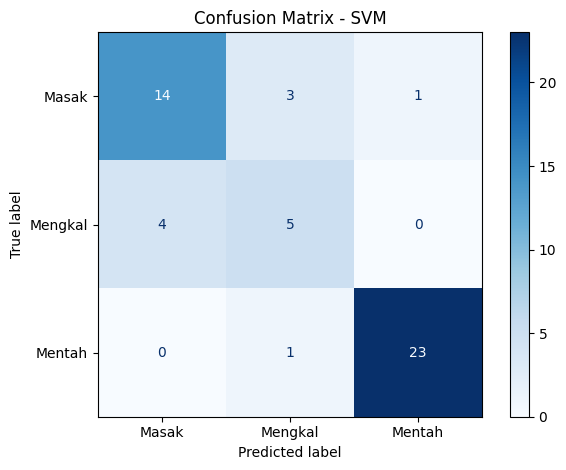

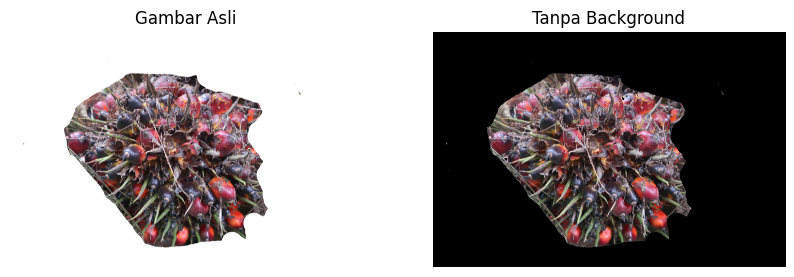

In [ ]:
# --- EVALUASI HASIL SVM ---
acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Akurasi Model: {acc*100:.2f}%")

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

# --- VISUALISASI CONFUSION MATRIX UNTUK SVM ---
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
plt.title('Confusion Matrix - SVM')
plt.tight_layout()
plt.show()

# --- VISUALISASI GAMBAR (SATU CONTOH) ---
contoh_path = os.path.join(base_path, 'Masak', '(1) masak.JPG')  # ubah sesuai nama file di folder
show_removed_background(contoh_path)

In [ ]:
len(X_test)

51